In [104]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [105]:
# Define the path to your training data
# The '../' goes up one level from 'notebooks/' to the project root
train_data_path = "../data/main/train/"

# Get a list of all captcha image paths
image_paths = sorted(glob.glob(os.path.join(train_data_path, "*.png")))
print(f"Found {len(image_paths)} images in the training folder.")

# --- Task: Extract all labels and create the character vocabulary ---

# 1. Get all labels from the filenames
labels = [os.path.basename(path).split('-')[0] for path in image_paths]

# 2. Find all unique characters present in the dataset
all_characters = set()
for label in labels:
    for char in label:
        all_characters.add(char)

# Convert the set to a sorted list to ensure consistent mapping
vocabulary = sorted(list(all_characters))

print(f"\nNumber of unique characters found: {len(vocabulary)}")
print(f"Vocabulary: {''.join(vocabulary)}")

# 3. Create the character-to-number and number-to-character dictionaries
char_to_num = {char: i + 1 for i, char in enumerate(vocabulary)}
# We add a dummy character at index 0 for the CTC 'blank' token
num_to_char = {i + 1: char for i, char in enumerate(vocabulary)}

print("\nCharacter to Number Mapping (char_to_num):")
print(char_to_num)

print("\nNumber to Character Mapping (num_to_char):")
print(num_to_char)

Found 8010 images in the training folder.

Number of unique characters found: 36
Vocabulary: 0123456789abcdefghijklmnopqrstuvwxyz

Character to Number Mapping (char_to_num):
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36}

Number to Character Mapping (num_to_char):
{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'a', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'h', 19: 'i', 20: 'j', 21: 'k', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'q', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'y', 36: 'z'}


Original image shape: (80, 540, 3)


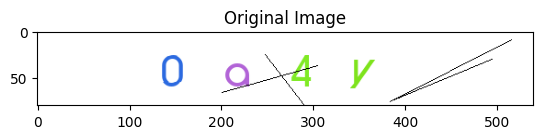

In [106]:
# --- Step A: Load and Display the Original Image ---

# Let's pick a sample image to work with
sample_image_path = "../data/main/train/0a4y-0.png" 

# Load the image using OpenCV
original_image = cv2.imread(sample_image_path)

# Matplotlib expects images in RGB format, but OpenCV loads them in BGR.
# We need to convert it to display the colors correctly.
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

print(f"Original image shape: {original_image.shape}") # (Height, Width, Channels)
plt.imshow(rgb_image)
plt.title("Original Image")
plt.show()

Grayscale image shape: (80, 540)


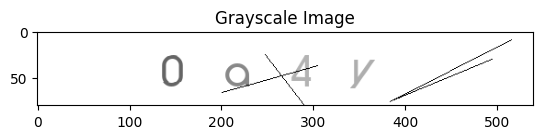

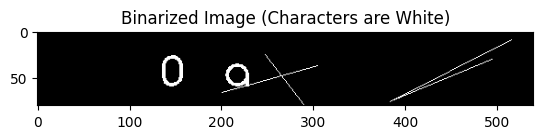

In [107]:
# --- Step B: Convert to Grayscale --- FAILED!!! DO NOT USE THIS
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

print(f"Grayscale image shape: {gray_image.shape}")
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.show()


# --- Step C: Binarize the image using Otsu's Thresholding ---
# This converts the image to pure black and white, removing noise.
# THRESH_BINARY_INV makes the characters white (255) and background black (0).
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.title("Binarized Image (Characters are White)")
plt.show()

In [108]:
# --- Find the maximum width needed for our images ---

train_image_paths = glob.glob("../data/main/train/*.png")
IMG_HEIGHT = 50
max_width = 0

print("Calculating maximum image width...")

for path in train_image_paths:
    # Load image just to get its dimensions
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded correctly
    if img is None:
        print(f"Warning: Could not load image {path}")
        continue
        
    h, w = img.shape
    
    # Calculate the new width after resizing to IMG_HEIGHT
    scale_factor = IMG_HEIGHT / h
    new_w = int(w * scale_factor)
    
    # Update the maximum width if this one is larger
    if new_w > max_width:
        max_width = new_w

print(f"\nMaximum resized image width found: {max_width}")
# Let's use a slightly larger, round number for safety
IMG_WIDTH = max_width + 8 # Add a little padding
print(f"Using IMG_WIDTH = {IMG_WIDTH} for our model.")

Calculating maximum image width...

Maximum resized image width found: 487
Using IMG_WIDTH = 495 for our model.



Final image shape for model: (495, 50, 1)


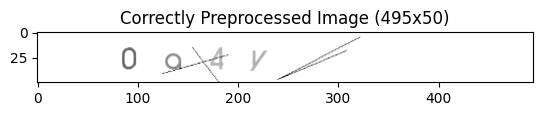

In [109]:
# This function is now correct because IMG_WIDTH is defined above
def prepare_image_for_crnn(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    """Loads and prepares an image for the CRNN model."""
    
    # 1. Read image and convert to grayscale.
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 2. Resize to fixed height, maintaining aspect ratio.
    h, w = img.shape
    scale = img_height / h
    new_w = int(w * scale)
    img = cv2.resize(img, (new_w, img_height))
    
    # 3. Pad the image to the target width.
    target = np.ones((img_height, img_width)) * 255 # White padding
    # This line will now work correctly
    target[:, :new_w] = img
    
    # 4. Normalize pixel values to [0, 1] range.
    img = target.astype(np.float32) / 255.0
    
    # 5. Transpose for the RNN.
    img = np.transpose(img, (1, 0))
    
    # 6. Add the channel dimension.
    img = np.expand_dims(img, axis=-1)
    
    return img

# --- Test and Visualize ---
sample_image_path = "../data/main/train/0a4y-0.png"
processed_img = prepare_image_for_crnn(sample_image_path)

print(f"\nFinal image shape for model: {processed_img.shape}")

# To visualize, we need to undo the transpose and remove the last dimension
plt.imshow(np.transpose(processed_img[:, :, 0], (1, 0)), cmap='gray')
plt.title(f"Correctly Preprocessed Image ({IMG_WIDTH}x{IMG_HEIGHT})")
plt.show()

Displaying 10 random samples...


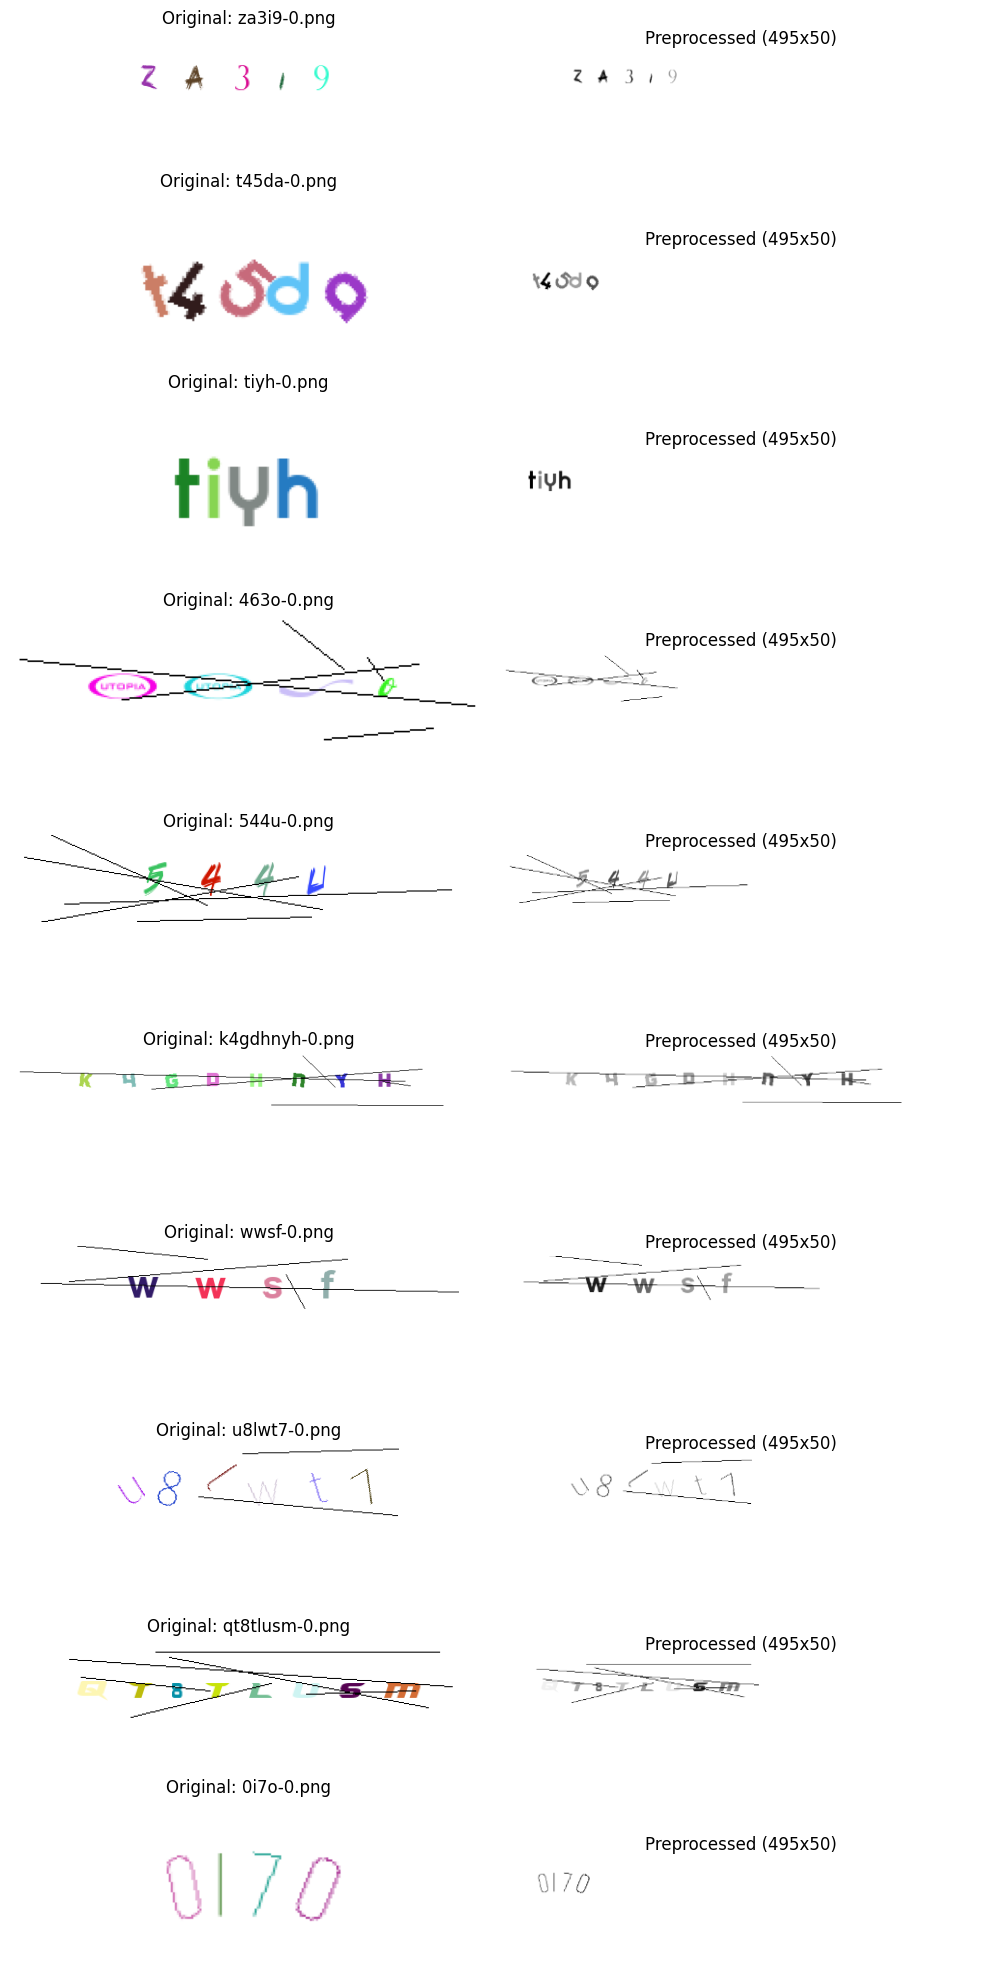

In [110]:
# --- Step 1: Get all image paths and select 10 random samples ---

# Make sure these are defined from your previous cell
# IMG_WIDTH = ...
# IMG_HEIGHT = ...

all_train_paths = glob.glob("../data/main/train/*.png")
num_samples_to_show = 10
random_sample_paths = random.sample(all_train_paths, num_samples_to_show)

print(f"Displaying {num_samples_to_show} random samples...")

# --- Step 2: Create a figure to display the results ---
# We create a grid of subplots: 10 rows, 2 columns
fig, axes = plt.subplots(nrows=num_samples_to_show, ncols=2, figsize=(10, 20))

# --- Step 3: Loop through the random samples and process/display them ---

for i, image_path in enumerate(random_sample_paths):
    
    # --- Left Column: The Original Image ---
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    ax = axes[i, 0]
    ax.imshow(rgb_img)
    ax.set_title(f"Original: {os.path.basename(image_path)}")
    ax.axis('off') # Hide the x and y axes
    
    
    # --- Right Column: The Preprocessed Image ---
    
    # Use the function you already created!
    processed_img = prepare_image_for_crnn(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT)
    
    # To display the processed image, we need to undo the transpose and remove the channel dimension
    # Shape goes from (width, height, 1) -> (width, height) -> (height, width)
    display_img = np.transpose(processed_img.squeeze(), (1, 0))

    ax = axes[i, 1]
    ax.imshow(display_img, cmap='gray')
    ax.set_title(f"Preprocessed ({IMG_WIDTH}x{IMG_HEIGHT})")
    ax.axis('off')

# Adjust layout to prevent titles from overlapping and show the plot
plt.tight_layout()
plt.show()

In [111]:
class CRNNCaptchaModel(keras.Model):
    def __init__(self, img_width, img_height, vocab_size):
        super(CRNNCaptchaModel, self).__init__()
        self.img_width = img_width
        self.img_height = img_height
        self.vocab_size = vocab_size
        self.model = None
        
        self.build_model()

    def build_model(self):
        # Input layer
        input_img = layers.Input(
            shape=(self.img_width, self.img_height, 1),
            name='image',
            dtype='float32'
        )
        
        print(f"Input shape: {input_img.shape}")
        
        # === CONVOLUTIONAL LAYERS ===
        
        # Block 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
        x = layers.MaxPooling2D((2, 2), name='pool1')(x)
        print(f"After Conv Block 1: {x.shape}")
        
        # Block 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
        x = layers.MaxPooling2D((2, 2), name='pool2')(x)
        print(f"After Conv Block 2: {x.shape}")
        
        # Block 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)
        x = layers.BatchNormalization(name='bn1')(x)
        x = layers.MaxPooling2D((2, 1), name='pool3')(x)
        print(f"After Conv Block 3: {x.shape}")
        
        # Block 4
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4')(x)
        x = layers.BatchNormalization(name='bn2')(x)
        x = layers.MaxPooling2D((2, 1), name='pool4')(x)
        print(f"After Conv Block 4: {x.shape}")
        
        # Block 5
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv5')(x)
        x = layers.BatchNormalization(name='bn3')(x)
        print(f"After Conv Block 5: {x.shape}")
        
        # === RESHAPE FOR RNN ===
        conv_output_width = x.shape[1]   # Gets 30
        conv_output_height = x.shape[2]  # Gets 12
        num_filters = x.shape[3]         # Gets 256

        new_features = conv_output_height * num_filters  # 12 * 256 = 3072

        x = layers.Reshape(target_shape=(conv_output_width, new_features), name='reshape')(x)
        print(f"After Reshape: {x.shape}")  # Should be (None, 30, 3072)
        
        # Dense layer
        x = layers.Dense(64, activation='relu', name='dense1')(x)
        x = layers.Dropout(0.2, name='dropout1')(x)
        print(f"After Dense: {x.shape}")
        
        # === RECURRENT LAYERS ===
        
        x = layers.Bidirectional(
            layers.LSTM(128, return_sequences=True, dropout=0.25),
            name='bidirectional_lstm_1'
        )(x)
        print(f"After Bidirectional LSTM 1: {x.shape}")
        
        x = layers.Bidirectional(
            layers.LSTM(64, return_sequences=True, dropout=0.25),
            name='bidirectional_lstm_2'
        )(x)
        print(f"After Bidirectional LSTM 2: {x.shape}")
        
        # === OUTPUT LAYER ===
        output = layers.Dense(
            self.vocab_size + 1,
            activation=None,  # Changed from 'softmax' to None for CTC loss
            name='output'
        )(x)
        print(f"Output shape: {output.shape}")
        
        # Create the model
        self.model = keras.models.Model(inputs=input_img, outputs=output, name='CRNN_CAPTCHA')

    def get_model(self):
        return self.model
    
    def summary(self):
        return self.model.summary()
    
    def compile(self, optimizer, loss):
        self.model.compile(optimizer=optimizer, loss=loss)
        print("Model compiled.")

    def train(self, train_generator, val_generator, epochs, callbacks):
        """Train the model."""
        history = self.model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    
    def predict(self, images):
        """Make predictions on images."""
        return self.model.predict(images)
    
    def save(self, filepath):
        """Save the model."""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")
    
    def load(self, filepath):
        """Load a saved model."""
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")

In [112]:
print(IMG_WIDTH, IMG_HEIGHT, len(vocabulary))
model = CRNNCaptchaModel(img_width=IMG_WIDTH, img_height=IMG_HEIGHT, vocab_size=len(vocabulary)).get_model()
model.summary()

495 50 36
Input shape: (None, 495, 50, 1)
After Conv Block 1: (None, 247, 25, 32)
After Conv Block 2: (None, 123, 12, 64)
After Conv Block 3: (None, 61, 12, 128)
After Conv Block 4: (None, 30, 12, 128)
After Conv Block 5: (None, 30, 12, 256)
After Reshape: (None, 30, 3072)
After Dense: (None, 30, 64)
After Bidirectional LSTM 1: (None, 30, 256)
After Bidirectional LSTM 2: (None, 30, 128)
Output shape: (None, 30, 37)


Model: "CRNN_CAPTCHA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 495, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 495, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 247, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 247, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 123, 12, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 123, 12, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 123, 12, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 61, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 61, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 61, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 30, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 30, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 30, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 3072)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 30, 64)         │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 30, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 30, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 30, 37)         │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,901 (4.20 MB)

 Trainable params: 1,099,877 (4.20 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [113]:
# === DATA GENERATOR CLASS ===

class CaptchaDataGenerator(keras.utils.Sequence):
    """Custom data generator for CAPTCHA images."""
    
    def __init__(self, image_paths, labels, char_to_num, 
                 img_width, img_height, batch_size=32, 
                 max_label_length=5, shuffle=True):
        """
        Initialize the data generator.
        
        Args:
            image_paths: List of paths to images
            labels: List of corresponding labels (strings)
            char_to_num: Dictionary mapping characters to numbers
            img_width: Width to resize images to
            img_height: Height to resize images to
            batch_size: Number of samples per batch
            max_label_length: Maximum length of labels
            shuffle: Whether to shuffle data after each epoch
        """
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_num = char_to_num
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.max_label_length = max_label_length
        self.shuffle = shuffle
        
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        """Return the number of batches per epoch."""
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get batch indexes
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get batch data
        batch_paths = [self.image_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y
    
    def on_epoch_end(self):
        """Shuffle indexes after each epoch if shuffle=True."""
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_paths, batch_labels):
        """Generate batch of images and labels."""
        # Initialize arrays
        X = np.zeros((self.batch_size, self.img_width, self.img_height, 1), 
                     dtype=np.float32)
        y = np.zeros((self.batch_size, self.max_label_length), dtype=np.float32)
        
        for i, (img_path, label) in enumerate(zip(batch_paths, batch_labels)):
            # Load and preprocess image
            img = prepare_image_for_crnn(img_path, self.img_width, self.img_height)
            X[i] = img
            
            # Encode label (convert characters to numbers)
            encoded_label = [self.char_to_num[char] for char in label]
            
            # Pad with -1 (to distinguish from CTC blank token which is 0)
            padded_label = encoded_label + [-1] * (self.max_label_length - len(encoded_label))
            y[i] = padded_label[:self.max_label_length]
        
        return X, y

In [114]:
# === PREPARE DATA SPLIT ===

from sklearn.model_selection import train_test_split

# Define paths
train_data_path = "../data/main/train/"
test_data_path = "../data/main/test/"

# Load training data
train_paths = sorted(glob.glob(os.path.join(train_data_path, "*.png")))
train_labels = [os.path.basename(path).split('-')[0] for path in train_paths]

# Load test data
test_paths = sorted(glob.glob(os.path.join(test_data_path, "*.png")))
test_labels = [os.path.basename(path).split('-')[0] for path in test_paths]

# Find maximum label length
all_labels = train_labels + test_labels
max_label_len = max([len(label) for label in all_labels])

print(f"Training samples: {len(train_paths)}")
print(f"Testing samples: {len(test_paths)}")
print(f"Maximum label length: {max_label_len}")

# Split training data into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, 
    train_labels, 
    test_size=0.1,  # 10% for validation
    random_state=42
)

print(f"\nAfter split:")
print(f"  Training samples: {len(train_paths)}")
print(f"  Validation samples: {len(val_paths)}")
print(f"  Test samples: {len(test_paths)}")

Training samples: 8010
Testing samples: 2000
Maximum label length: 8

After split:
  Training samples: 7209
  Validation samples: 801
  Test samples: 2000


In [115]:
# === CREATE DATA GENERATORS ===

print("\nCreating data generators...")

train_generator = CaptchaDataGenerator(
    train_paths, 
    train_labels, 
    char_to_num,
    IMG_WIDTH, 
    IMG_HEIGHT,
    batch_size=128,
    max_label_length=max_label_len,
    shuffle=True
)

val_generator = CaptchaDataGenerator(
    val_paths, 
    val_labels, 
    char_to_num,
    IMG_WIDTH, 
    IMG_HEIGHT,
    batch_size=128,
    max_label_length=max_label_len,
    shuffle=False  # Don't shuffle validation data
)

test_generator = CaptchaDataGenerator(
    test_paths, 
    test_labels, 
    char_to_num,
    IMG_WIDTH, 
    IMG_HEIGHT,
    batch_size=128,
    max_label_length=max_label_len,
    shuffle=False  # Don't shuffle test data
)

print(f"✓ Training batches: {len(train_generator)}")
print(f"✓ Validation batches: {len(val_generator)}")
print(f"✓ Test batches: {len(test_generator)}")


Creating data generators...
✓ Training batches: 56
✓ Validation batches: 6
✓ Test batches: 15


In [116]:
# === TEST THE GENERATOR ===

print("\nTesting generator output...")
X_sample, y_sample = train_generator[0]

print(f"\nSample batch shapes:")
print(f"  Images (X): {X_sample.shape}")
print(f"  Labels (y): {y_sample.shape}")
print(f"\nFirst 3 labels in batch:")
for i in range(min(3, len(y_sample))):
    print(f"  Label {i}: {y_sample[i]}")


Testing generator output...

Sample batch shapes:
  Images (X): (128, 495, 50, 1)
  Labels (y): (128, 8)

First 3 labels in batch:
  Label 0: [13.  8. 28.  3. 15. -1. -1. -1.]
  Label 1: [ 4. 34. 16. 32. 19. -1. -1. -1.]
  Label 2: [35.  8. 32. 26.  1. 29. -1. -1.]


In [117]:
# === CTC LOSS FUNCTION ===

def ctc_loss_function(y_true, y_pred):
    """
    CTC (Connectionist Temporal Classification) Loss.
    Allows the model to learn alignment between input and output sequences.
    """
    # Get batch size and sequence lengths
    batch_size = tf.shape(y_true)[0]
    label_length = tf.shape(y_true)[1]
    pred_length = tf.shape(y_pred)[1]
    
    # Calculate actual label lengths (count non-padding tokens)
    # Padding tokens are -1, so we count tokens >= 0
    label_lengths = tf.reduce_sum(tf.cast(y_true >= 0, dtype="int32"), axis=1)
    
    # Input length is same for all samples (model output sequence length)
    input_lengths = tf.fill([batch_size], pred_length)
    
    # Replace -1 padding with 0 for CTC (CTC uses 0 as blank)
    # FIX: Cast 0.0 to float32 to match y_true's type
    y_true_clean = tf.where(y_true < 0, tf.constant(0.0, dtype=y_true.dtype), y_true)
    y_true_clean = tf.cast(y_true_clean, dtype="int32")
    
    # Ensure label_lengths and input_lengths are 1D
    label_lengths = tf.cast(tf.reshape(label_lengths, [-1]), dtype="int32")
    input_lengths = tf.cast(tf.reshape(input_lengths, [-1]), dtype="int32")
    
    # Compute CTC loss
    loss = tf.nn.ctc_loss(
        labels=y_true_clean,
        logits=y_pred,
        label_length=label_lengths,
        logit_length=input_lengths,
        logits_time_major=False,
        blank_index=0
    )
    
    return tf.reduce_mean(loss)

print("✓ CTC loss function defined")

✓ CTC loss function defined


In [118]:
# === INSTANTIATE AND COMPILE MODEL ===

# Calculate vocab size
vocab_size = len(vocabulary)

print(f"Building model with:")
print(f"  Image size: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Max label length: {max_label_len}")
print("\n" + "="*60)

# Instantiate the model (this automatically calls build_model)
crnn_model = CRNNCaptchaModel(IMG_WIDTH, IMG_HEIGHT, vocab_size)

print("="*60)
print("\n✓ Model built successfully!")

# Compile the model using the class method
crnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=ctc_loss_function
)

# Display model summary using the class method
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
crnn_model.summary()

Building model with:
  Image size: 495x50
  Vocabulary size: 36
  Max label length: 8

Input shape: (None, 495, 50, 1)
After Conv Block 1: (None, 247, 25, 32)
After Conv Block 2: (None, 123, 12, 64)
After Conv Block 3: (None, 61, 12, 128)
After Conv Block 4: (None, 30, 12, 128)
After Conv Block 5: (None, 30, 12, 256)
After Reshape: (None, 30, 3072)
After Dense: (None, 30, 64)
After Bidirectional LSTM 1: (None, 30, 256)
After Bidirectional LSTM 2: (None, 30, 128)
Output shape: (None, 30, 37)

✓ Model built successfully!
Model compiled.

MODEL SUMMARY


Model: "CRNN_CAPTCHA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 495, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 495, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 247, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 247, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 123, 12, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 123, 12, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 123, 12, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 61, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 61, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 61, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 30, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 30, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 30, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 3072)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 30, 64)         │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 30, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 30, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 30, 37)         │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,901 (4.20 MB)

 Trainable params: 1,099,877 (4.20 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [119]:
# === TRAIN THE MODEL ===

# Setup callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/best_crnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

history = crnn_model.train(
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


STARTING TRAINING
Epoch 1/25


/opt/anaconda3/envs/cs4243/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 33.2017
Epoch 1: val_loss improved from inf to 23.57124, saving model to ../models/best_crnn_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 33.0784 - val_loss: 23.5712 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 23.4490
Epoch 2: val_loss did not improve from 23.57124
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 23.4482 - val_loss: 23.6574 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 23.3665
Epoch 3: val_loss did not improve from 23.57124
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 23.3665 - val_loss: 23.8519 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 23.3188
Epoch 4: val_loss improved from 23.57124 to 23.46562, saving model to ../models/best_crnn_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 23.3182 - val_loss: 23.4656 - learning_rate: 0.0010
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 23.

In [120]:
def decode_batch_predictions(pred):
    """
    Decode CTC predictions to text.
    
    Args:
        pred: Model prediction (logits) of shape (batch_size, timesteps, num_classes)
    
    Returns:
        List of decoded text strings
    """
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use CTC greedy decoder
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    # Convert to text
    output_text = []
    for result in results:
        result = result.numpy()
        # Convert indices to characters, skip blank (0)
        text = ''.join([num_to_char.get(int(idx), '') for idx in result if int(idx) != 0])
        output_text.append(text)
    
    return output_text

print("✓ Decode function defined")

✓ Decode function defined


In [121]:
# === UPDATED PREDICT FUNCTION ===

def predict_captcha(image_path, model=None):
    """
    Predict CAPTCHA text from any image.
    
    Args:
        image_path: Path to image
        model: Trained model (if None, uses crnn_model.model)
    """
    # Use the internal model if no model specified
    if model is None:
        model = crnn_model.model
    
    # Preprocess
    img = prepare_image_for_crnn(image_path, IMG_WIDTH, IMG_HEIGHT)
    img_batch = np.expand_dims(img, axis=0)
    
    # Predict
    pred = model.predict(img_batch, verbose=0)
    
    # Debug: Check prediction values
    print(f"Prediction shape: {pred.shape}")
    print(f"Prediction range: [{np.min(pred):.4f}, {np.max(pred):.4f}]")
    
    predicted_text = decode_batch_predictions(pred)[0]
    
    # Display
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Get actual label
    actual_label = os.path.basename(image_path).split('-')[0]
    
    plt.figure(figsize=(12, 4))
    plt.imshow(rgb_img)
    
    is_correct = (actual_label == predicted_text)
    color = 'green' if is_correct else 'red'
    
    plt.title(f"Actual: '{actual_label}' | Predicted: '{predicted_text}'", 
              fontsize=14, weight='bold', color=color)
    plt.axis('off')
    plt.show()
    
    print(f"Actual:    '{actual_label}'")
    print(f"Predicted: '{predicted_text}'")
    print(f"Match: {'✓' if is_correct else '✗'}")
    
    return predicted_text

In [122]:
# === LOAD TRAINED MODEL FROM FILE ===

import os

# Path to the saved model
MODEL_PATH = '../models/best_crnn_model.keras'

# Check if model exists
if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Model file not found at {MODEL_PATH}")
    print("Make sure training has completed and the model was saved.")
else:
    print(f"✓ Found model at {MODEL_PATH}")
    
    # Load the model with custom loss function
    loaded_model = keras.models.load_model(
        MODEL_PATH,
        custom_objects={'ctc_loss_function': ctc_loss_function}
    )
    
    print("✓ Model loaded successfully!")
    print(f"Model input shape: {loaded_model.input_shape}")
    print(f"Model output shape: {loaded_model.output_shape}")

✓ Found model at ../models/best_crnn_model.keras
✓ Model loaded successfully!
Model input shape: (None, 495, 50, 1)
Model output shape: (None, 30, 37)


Prediction shape: (1, 30, 37)
Prediction range: [-4.5114, 10.5267]
Prediction std dev: 2.2545


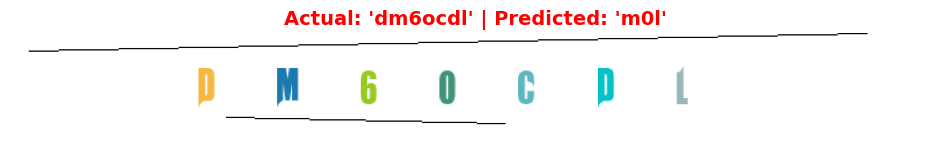


Actual:    'dm6ocdl'
Predicted: 'm0l'
Match:     ✗


'm0l'

In [128]:
# === TEST WITH LOADED MODEL ===

def predict_with_loaded_model(image_path):
    """
    Predict CAPTCHA text using the loaded model.
    """
    if 'loaded_model' not in globals():
        print("❌ ERROR: Model not loaded. Run the previous cell first.")
        return None
    
    # Preprocess
    img = prepare_image_for_crnn(image_path, IMG_WIDTH, IMG_HEIGHT)
    img_batch = np.expand_dims(img, axis=0)
    
    # Predict with the LOADED model
    pred = loaded_model.predict(img_batch, verbose=0)
    
    # Debug info
    print(f"Prediction shape: {pred.shape}")
    print(f"Prediction range: [{np.min(pred):.4f}, {np.max(pred):.4f}]")
    
    # Check if predictions are meaningful
    pred_std = np.std(pred)
    print(f"Prediction std dev: {pred_std:.4f}")
    
    if pred_std < 0.1:
        print("⚠️ WARNING: Very low std dev - model may not be trained properly")
    
    # Decode
    predicted_text = decode_batch_predictions(pred)[0]
    
    # Display
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    actual_label = os.path.basename(image_path).split('-')[0]
    
    plt.figure(figsize=(12, 4))
    plt.imshow(rgb_img)
    
    is_correct = (actual_label == predicted_text)
    color = 'green' if is_correct else 'red'
    
    title = f"Actual: '{actual_label}' | Predicted: '{predicted_text}'"
    if predicted_text == '':
        title += " (EMPTY!)"
    
    plt.title(title, fontsize=14, weight='bold', color=color)
    plt.axis('off')
    plt.show()
    
    print(f"\nActual:    '{actual_label}'")
    print(f"Predicted: '{predicted_text}'")
    print(f"Match:     {'✓' if is_correct else '✗'}")
    
    return predicted_text

# Test it
predict_with_loaded_model("../data/main/test/dm6ocdl-0.png")

In [127]:
# === DETAILED DIAGNOSIS ===

def diagnose_model_predictions(image_path):
    """Deep dive into what the model is predicting."""
    
    if 'loaded_model' not in globals():
        print("❌ ERROR: Model not loaded")
        return
    
    print(f"\n{'='*70}")
    print("DETAILED PREDICTION DIAGNOSIS")
    print(f"{'='*70}")
    
    # Preprocess
    img = prepare_image_for_crnn(image_path, IMG_WIDTH, IMG_HEIGHT)
    img_batch = np.expand_dims(img, axis=0)
    
    # Get raw predictions (logits)
    pred = loaded_model.predict(img_batch, verbose=0)
    
    print(f"\n1. RAW LOGITS:")
    print(f"   Shape: {pred.shape}")
    print(f"   Range: [{np.min(pred):.4f}, {np.max(pred):.4f}]")
    print(f"   Mean: {np.mean(pred):.4f}")
    print(f"   Std: {np.std(pred):.4f}")
    
    # Apply softmax to see probabilities
    pred_softmax = tf.nn.softmax(pred, axis=-1).numpy()
    
    print(f"\n2. AFTER SOFTMAX (Probabilities):")
    print(f"   Max probability: {np.max(pred_softmax):.4f}")
    print(f"   Min probability: {np.min(pred_softmax):.4f}")
    
    # Get predicted classes at each timestep
    pred_classes = np.argmax(pred_softmax[0], axis=-1)
    
    print(f"\n3. PREDICTED CLASSES PER TIMESTEP:")
    print(f"   First 10 timesteps: {pred_classes[:10]}")
    print(f"   Last 10 timesteps: {pred_classes[-10:]}")
    
    # Count predictions
    unique, counts = np.unique(pred_classes, return_counts=True)
    
    print(f"\n4. CLASS DISTRIBUTION:")
    print(f"   Unique classes predicted: {len(unique)}")
    print(f"   Most common class: {unique[np.argmax(counts)]} (count: {np.max(counts)})")
    
    # Check if blank token (0) dominates
    blank_count = np.sum(pred_classes == 0)
    blank_pct = (blank_count / len(pred_classes)) * 100
    
    print(f"\n5. BLANK TOKEN ANALYSIS:")
    print(f"   Blank predictions: {blank_count}/{len(pred_classes)} ({blank_pct:.1f}%)")
    
    if blank_pct > 95:
        print("   ❌ PROBLEM: Almost all predictions are blank!")
        print("      This means the model hasn't learned to recognize characters.")
    elif blank_pct > 80:
        print("   ⚠️ WARNING: Too many blank predictions")
    else:
        print("   ✓ Reasonable blank token usage")
    
    # CTC decode
    decoded = decode_batch_predictions(pred)[0]
    
    print(f"\n6. FINAL DECODED TEXT:")
    print(f"   Result: '{decoded}'")
    
    if decoded == '':
        print("   ❌ Empty string - CTC decoder removed everything")
        print("      Likely cause: All timesteps predicted as blank (class 0)")
    
    # Get actual label
    actual = os.path.basename(image_path).split('-')[0]
    print(f"   Actual: '{actual}'")
    
    print(f"\n{'='*70}")
    
    return pred, decoded

# Run detailed diagnosis
pred, text = diagnose_model_predictions("../data/main/test/dm6ocdl-0.png")


DETAILED PREDICTION DIAGNOSIS

1. RAW LOGITS:
   Shape: (1, 30, 37)
   Range: [-4.5114, 10.5267]
   Mean: -0.3267
   Std: 2.2545

2. AFTER SOFTMAX (Probabilities):
   Max probability: 0.9993
   Min probability: 0.0000

3. PREDICTED CLASSES PER TIMESTEP:
   First 10 timesteps: [ 0  0  0  0  0  1  0 23  0  0]
   Last 10 timesteps: [22  0  0  0  0  0  0  0  0  0]

4. CLASS DISTRIBUTION:
   Unique classes predicted: 7
   Most common class: 0 (count: 23)

5. BLANK TOKEN ANALYSIS:
   Blank predictions: 23/30 (76.7%)
   ✓ Reasonable blank token usage

6. FINAL DECODED TEXT:
   Result: 'm0l'
   Actual: 'dm6ocdl'



In [129]:
# === TEST ON MULTIPLE IMAGES ===

def test_multiple_from_loaded_model(num_samples=10):
    """Test multiple images to see if ANY work."""
    
    if 'loaded_model' not in globals():
        print("❌ Model not loaded")
        return
    
    print(f"\n{'='*70}")
    print(f"TESTING {num_samples} RANDOM IMAGES")
    print(f"{'='*70}\n")
    
    import random
    test_paths_sample = random.sample(train_paths, min(num_samples, len(test_paths)))
    
    results = []
    
    for img_path in test_paths_sample:
        actual = os.path.basename(img_path).split('-')[0]
        
        img = prepare_image_for_crnn(img_path, IMG_WIDTH, IMG_HEIGHT)
        img_batch = np.expand_dims(img, axis=0)
        pred = loaded_model.predict(img_batch, verbose=0)
        predicted = decode_batch_predictions(pred)[0]
        
        is_correct = (actual == predicted)
        results.append({
            'filename': os.path.basename(img_path),
            'actual': actual,
            'predicted': predicted,
            'correct': is_correct
        })
        
        status = '✓' if is_correct else '✗'
        pred_display = predicted if predicted else '(empty)'
        print(f"{status} {os.path.basename(img_path):20s} | Actual: {actual:6s} | Predicted: {pred_display:6s}")
    
    # Summary
    correct = sum(1 for r in results if r['correct'])
    empty = sum(1 for r in results if r['predicted'] == '')
    total = len(results)
    
    print(f"\n{'='*70}")
    print(f"SUMMARY:")
    print(f"  Total:    {total}")
    print(f"  Correct:  {correct} ({(correct/total)*100:.1f}%)")
    print(f"  Wrong:    {total - correct}")
    print(f"  Empty:    {empty}")
    print(f"{'='*70}")
    
    if empty == total:
        print("\n❌ CRITICAL: ALL predictions are empty!")
        print("   Your model is NOT properly trained or weights didn't load correctly.")
        print("\n   Possible causes:")
        print("   1. Model was trained for too few epochs (you used epochs=3)")
        print("   2. Training didn't converge")
        print("   3. Wrong model file is being loaded")
        print("\n   Try:")
        print("   - Check the training loss - did it decrease?")
        print("   - Train for more epochs (50+)")
    
    return results

# Test multiple images
results = test_multiple_from_loaded_model(10)


TESTING 10 RANDOM IMAGES

✗ bme347-0.png         | Actual: bme347 | Predicted: m3q3  
✗ 3lkh9-0.png          | Actual: 3lkh9  | Predicted: 3k3   
✗ bc8eexe-0.png        | Actual: bc8eexe | Predicted: wmk   
✗ gjavy-0.png          | Actual: gjavy  | Predicted: ja4y  
✗ om9t6d-0.png         | Actual: om9t6d | Predicted: om9j0 
✗ 4jynch-0.png         | Actual: 4jynch | Predicted: a7ynh 
✗ 2jrl-0.png           | Actual: 2jrl   | Predicted: jpl   
✗ fhogkd-0.png         | Actual: fhogkd | Predicted: hh0   
✗ 7h8xyp-0.png         | Actual: 7h8xyp | Predicted: 7n8xv 
✗ 8gr6z-0.png          | Actual: 8gr6z  | Predicted: 80p6  

SUMMARY:
  Total:    10
  Correct:  0 (0.0%)
  Wrong:    10
  Empty:    0
